# **Introduction**

The NYC Taxi Trip Dataset contains detailed trip records from taxis in New York City, dating
back to 2009. This dataset, provided by the NYC Taxi and Limousine Commission (TLC),
captures billions of taxi rides, making it one of the largest publicly available datasets for urban
transportation research.


# **Features**
Key Features of the Dataset
Each row in the dataset represents a single taxi trip and contains the following key features:
- Pickup and Drop-off Timestamps: The time when a trip starts and ends
- Pickup and Drop-off Locations: Latitude and longitude coordinates of where the trip
begins and ends
- Trip Distance: The distance traveled during the trip (in miles)
- Fare Amount: Total cost of the trip, including base fare, taxes, and surcharges
- Payment Type: The method of payment used (e.g., cash or card)

These features provide crucial insights into trip duration, travel patterns, pricing, and customer
behavior

# **Collection Process**
The dataset is collected by the NYC Taxi and Limousine Commission (TLC) from yellow and
green taxis operating in the city. Each taxi is equipped with a GPS-enabled meter that records
key details of every trip, including pickup/drop-off locations, fare, and payment method. The data
is collected in real-time and stored in the TLC's central database, then anonymized and made
available to the public for analysis.

# **Structure**
We will be focusing on Yellow Taxi trips. The dataset is already available in Parquet format.

# **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Big_Data/Project_3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Installing Pyspark**

In [ ]:
!pip install pyspark

# **Importing all required libraries**

In [ ]:
# Data handling and processing
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation

# Machine learning & clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# **Initializing Spark Session**

In [ ]:
spark = SparkSession.builder.appName("CombineParquetFiles").getOrCreate()

NameError: name 'SparkSession' is not defined

# **Combining all months into one file**

In [ ]:
df = spark.read.parquet("/content/drive/MyDrive/Big_Data/Project_3/Data")

df.printSchema()

df.write.mode("overwrite").parquet("/content/drive/MyDrive/Big_Data/Project_3/Data/combined_data.parquet")

# **Feature Engineering**

For the Data Pre Processing we did,
Read and Initialize Data: Loaded the combined dataset from a Parquet file.

- Timestamp Conversion: Converted tpep_pickup_datetime and tpep_dropoff_datetime columns to timestamp format to ensure that datetime operations can be applied.

- Date and Time Extraction: Created new columns to capture specific date and time components from both the pickup and dropoff timestamps:

    - `pickup_date` and `dropoff_date`: extracted just the date (year-month-day).
    - `pickup_hour` and `dropoff_hour`: extracted the hour of the day.
    - `pickup_day_of_week` and `dropoff_day_of_week`: extracted the day of the week.
    - `pickup_week` and `dropoff_week`: extracted the week of the year.
    - `pickup_month` and `dropoff_month`: extracted the month.
- Trip Duration Calculation: Calculated the trip duration in minutes by taking
  the difference between the dropoff and pickup timestamps and dividing by 60.
- Preview the Data: Displayed the first few rows of the DataFrame with the newly added columns to verify the transformations.

In [ ]:
combined_df = spark.read.parquet("/content/drive/MyDrive/Big_Data/Project_3/Data/combined_data.parquet")

combined_df = combined_df \
    .withColumn("tpep_pickup_datetime", F.to_timestamp("tpep_pickup_datetime")) \
    .withColumn("tpep_dropoff_datetime", F.to_timestamp("tpep_dropoff_datetime"))

combined_df = combined_df \
    .withColumn("pickup_date", F.to_date("tpep_pickup_datetime")) \
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime")) \
    .withColumn("pickup_day_of_week", F.dayofweek("tpep_pickup_datetime")) \
    .withColumn("pickup_week", F.weekofyear("tpep_pickup_datetime")) \
    .withColumn("pickup_month", F.month("tpep_pickup_datetime")) \
    .withColumn("dropoff_date", F.to_date("tpep_dropoff_datetime")) \
    .withColumn("dropoff_hour", F.hour("tpep_dropoff_datetime")) \
    .withColumn("dropoff_day_of_week", F.dayofweek("tpep_dropoff_datetime")) \
    .withColumn("dropoff_week", F.weekofyear("tpep_dropoff_datetime")) \
    .withColumn("dropoff_month", F.month("tpep_dropoff_datetime"))

combined_df = combined_df.withColumn(
    "trip_duration",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60
)

combined_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+-----------+------------------+-----------+------------+------------+------------+-------------------+------------+-------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_date|pickup_hour|pickup_day_of_week|pickup_week|pickup_month|dropoff_date|dropoff_hour|dropoff_day_of_week|dropoff_week|dropoff_month|     trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------

# Identifying regions in the city with high demand for taxis.

### **Grouping by Pickup Location and Week**:
Aggregated taxi pickups by location (PULocationID) and week (pickup_week) to calculate weekly pickup counts, preparing data for temporal and spatial analysis.

In [ ]:
combined_df = combined_df.withColumn("pickup_week", F.weekofyear("tpep_pickup_datetime"))
pickup_counts = combined_df.groupBy("PULocationID", "pickup_week") \
                           .agg(F.count("*").alias("pickup_count"))

pickup_counts_pd = pickup_counts.toPandas()

### **GeoPandas Shapefile Processing:**
Loaded a shapefile of taxi zones, sets the CRS to NAD83, then converts it to WGS84 for latitude/longitude usage, and calculates the centroids of each zone for mapping purposes.

In [ ]:
gdf = gpd.read_file("/content/drive/MyDrive/Big_Data/Project_3/Data/taxi_zones.shp")

gdf = gdf.set_crs("EPSG:2263", allow_override=True)

gdf = gdf.to_crs("EPSG:4326")

gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x

taxi_zones_df = gdf[['LocationID', 'borough', 'latitude', 'longitude']]

<ipython-input-43-ba9281194af8>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.geometry.centroid.y
<ipython-input-43-ba9281194af8>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.geometry.centroid.x


### **Data Merging**:
Merged the weekly pickup counts DataFrame with the GeoPandas DataFrame (`taxi_zones_df`) on location ID, adding spatial data (`latitude`, `longitude`, `borough`) to the pickup counts.

In [ ]:
pickup_counts_pd = pickup_counts_pd.merge(taxi_zones_df, left_on="PULocationID", right_on="LocationID", how="left")

### **Standardization and DBSCAN Clustering and Map Visualization:**
Standardized the latitude, longitude, and pickup count data to improve clustering, then applies the DBSCAN clustering algorithm to identify clusters of high taxi demand. Visualized the DBSCAN clusters on a Mapbox scatter plot, where each cluster is colored, and the pickup count size scales the points, providing a visual overview of demand hotspots across zones.

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pickup_counts_pd[['latitude', 'longitude', 'pickup_count']])

dbscan = DBSCAN(eps=0.5, min_samples=10)
pickup_counts_pd['dbscan_cluster'] = dbscan.fit_predict(scaled_data)

px.set_mapbox_access_token("pk.eyJ1IjoidGFydW5rdW1hbmR1cmkiLCJhIjoiY20zM3AzMDhuMW1mZzJucTNsaHNkOHJvYyJ9.hLqcWDf8zBHxScBXcLpLqQ")

fig_dbscan = px.scatter_mapbox(
    pickup_counts_pd, lat='latitude', lon='longitude', color='dbscan_cluster',
    size='pickup_count', zoom=10, mapbox_style="carto-positron",
    title="Taxi Demand Clusters with DBSCAN"
)
fig_dbscan.show()

### **Interpretation of Results**
- **Cluster Identification**: Each dot represents a pickup location, with colors indicating different clusters identified by the DBSCAN algorithm. DBSCAN clusters points based on density, meaning areas with high taxi pickup activity are grouped into clusters.

- **Color Coding**: The color scale on the right ranges from -1 (representing noise or unclustered points) to various positive integers, each corresponding to a different cluster. Most locations are clustered in dense areas, primarily in Manhattan, where taxi demand is high. Some points outside the main clusters are labeled as noise (value -1) because they don’t meet the density requirements to form a cluster.

- **Size of Points**: The size of each point represents the pickup count, so larger points indicate locations with higher taxi pickup frequencies. This highlights the most popular pickup zones within each cluster.

- **Geographical Insight**: The map shows that the majority of clusters are centered around Manhattan and nearby areas, suggesting these locations have consistently high demand. A few isolated clusters (such as near JFK Airport) also show significant taxi pickup activity, indicating hotspot zones outside the main Manhattan area.

# Prediction of the duration of a taxi trip based on trip start time and location (pick up and drop off)

### -  **Outlier Detection and Removal**:
   - Calculated the interquartile range (IQR) for the `trip_duration` column to identify outliers.
   - Defined an upper bound as \( Q3 + 1.5 \times IQR \) to detect high trip durations that might be considered outliers.
   - Filtered out rows with null values and rows where `trip_duration` is greater than zero but below the defined upper bound, ensuring only valid and reasonable trip duration data is used.

### -  **Feature Vector Assembly**:
   - Used the `VectorAssembler` to combine multiple features (`pickup_hour`, `pickup_day_of_week`, `PULocationID`, `DOLocationID`, and `trip_distance`) into a single feature vector column. This prepares the data for machine learning, as the `RandomForestRegressor` expects a single vector for input features.

### - **Data Splitting**:
   - Split the data into training (80%) and testing (20%) sets to train the model and evaluate its performance on unseen data.

### - **Random Forest Model Training**:
   - Initialized a `RandomForestRegressor` with adjusted parameters (50 trees and a max depth of 10) to predict `trip_duration` based on the input features.
   - Trained the model on the training dataset.

###- **Model Predictions**:
   - Used the trained model to make predictions on the test data.

### - **Model Evaluation**:
   - Evaluated the model's performance using three metrics:
     - **Root Mean Squared Error (RMSE)**: Measures the average magnitude of prediction errors in terms of `trip_duration`.
     - **Mean Absolute Error (MAE)**: Represents the average absolute differences between predictions and actual values.
     - **R-squared (R²)**: Indicates how well the model explains the variance in `trip_duration`.

The printed metrics (RMSE, MAE, and R²) provide a summary of the model's accuracy and effectiveness in predicting trip durations.

In [ ]:
q1 = combined_df.approxQuantile("trip_duration", [0.25], 0.05)[0]
q3 = combined_df.approxQuantile("trip_duration", [0.75], 0.05)[0]
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

filtered_df = combined_df.filter(
    (combined_df["trip_duration"].isNotNull()) &
    (combined_df["pickup_hour"].isNotNull()) &
    (combined_df["pickup_day_of_week"].isNotNull()) &
    (combined_df["PULocationID"].isNotNull()) &
    (combined_df["DOLocationID"].isNotNull()) &
    (combined_df["trip_distance"].isNotNull()) &
    (combined_df["trip_duration"] > 0) &
    (combined_df["trip_duration"] <= upper_bound)
)

assembler = VectorAssembler(
    inputCols=["pickup_hour", "pickup_day_of_week", "PULocationID", "DOLocationID", "trip_distance"],
    outputCol="features"
)
data = assembler.transform(filtered_df).select("features", "trip_duration")

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration", numTrees=50, maxDepth=10)
model = rf.fit(train_data)

predictions = model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 3.8062247968257523
Mean Absolute Error (MAE): 2.7863077283545525
R-squared (R²): 0.7217702783651879


### **Model Performance Interpretation:**

**Root Mean Squared Error (RMSE)**: The RMSE of 3.81 minutes indicates that the model’s predictions for trip duration have an average error of approximately 3.81 minutes. This value reflects the typical deviation from actual trip durations, with lower RMSE values suggesting better accuracy.

**Mean Absolute Error (MAE)**: The MAE of 2.79 minutes represents the average absolute difference between predicted and actual trip durations. This shows that, on average, the model's predictions deviate by around 2.79 minutes from the true values.

**R-squared (R²)**: With an R² value of 0.72, the model explains 72% of the variance in trip duration, indicating a reasonably good fit. An R² closer to 1 would imply a better model fit, so while this model performs well, there is still potential for improvement.

**Overall Interpretation**: The model demonstrates a solid predictive capability, capturing most of the variation in trip durations with moderate prediction errors. Further refinement, such as additional feature engineering or hyperparameter tuning, could potentially improve accuracy.

**Justification**:
This model was built using features that logically impact trip duration, such as `trip_distance`, `pickup_borough`, `dropoff_borough`, `pickup_hour`, and `passenger_count`. These factors are relevant in determining the time required for a trip, as they capture both spatial (distance and boroughs) and temporal (pickup hour) influences on travel duration. Categorical data, like `pickup_borough` and `dropoff_borough`, were indexed and encoded to ensure that geographic characteristics were incorporated effectively. The Random Forest model was chosen due to its capability to handle complex relationships and interactions among features, making it suitable for predicting continuous variables like trip duration. The model's moderate RMSE and MAE scores, along with a reasonably high R² value, validate the feature selection and preprocessing steps, confirming that they were effective in creating a model that captures key patterns in trip duration. With further refinement, this model has potential for even greater accuracy, making it a valuable tool for travel time estimation.

# Segmentation of the passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method


### **Sampling the data and running Elbow method:**

This code samples data by month, prepares selected features for clustering, and uses the elbow method to identify the optimal number of clusters based on the WCSS, with the "elbow" point indicating the best `k` value.

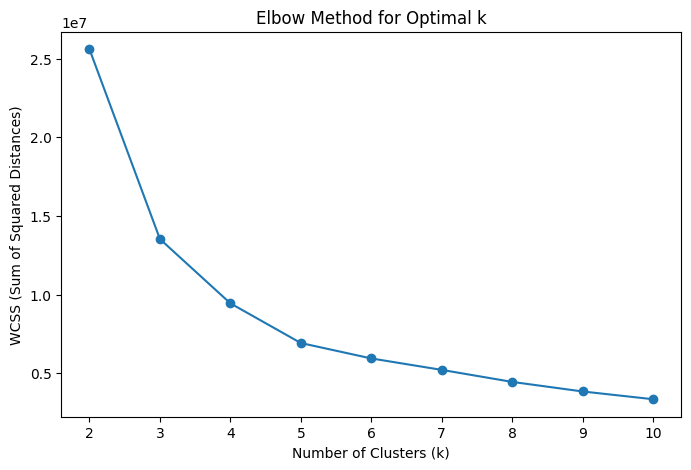

In [ ]:
sampled_df = combined_df.sampleBy("pickup_month", fractions={i: 25000 / combined_df.filter(F.col("pickup_month") == i).count() for i in range(1, 7)}, seed=42)

sampled_df = sampled_df.withColumn("is_card_payment", F.when(F.col("payment_type") == 1, 1).otherwise(0))

assembler = VectorAssembler(
    inputCols=["trip_distance", "fare_amount", "pickup_hour", "is_card_payment"],
    outputCol="features"
)
data = assembler.transform(sampled_df).select("features")

data_pd = data.toPandas()
features = pd.DataFrame(data_pd["features"].tolist(), columns=["trip_distance", "fare_amount", "pickup_hour", "is_card_payment"])

cost = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(data)
    cost.append(model.summary.trainingCost)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), cost, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.show()

The elbow plot shows the WCSS for each `k` value, where a sharp decline up to `k=5` suggests that four clusters might capture the main patterns in the data. After `k=5`, the rate of decrease slows, indicating diminishing returns with more clusters. Therefore, `k=5` is likely the optimal choice for clustering taxi trip characteristics effectively.

### **Running K Means Clustering with `k = 5`:**
The code removes extreme outliers in `trip_distance` and `fare_amount` to focus on typical taxi trips, then uses K-means clustering with `k=5` to identify patterns in trip characteristics. The resulting scatter plot shows clusters based on trip distance and fare amount, illustrating distinct groupings in taxi trip data.

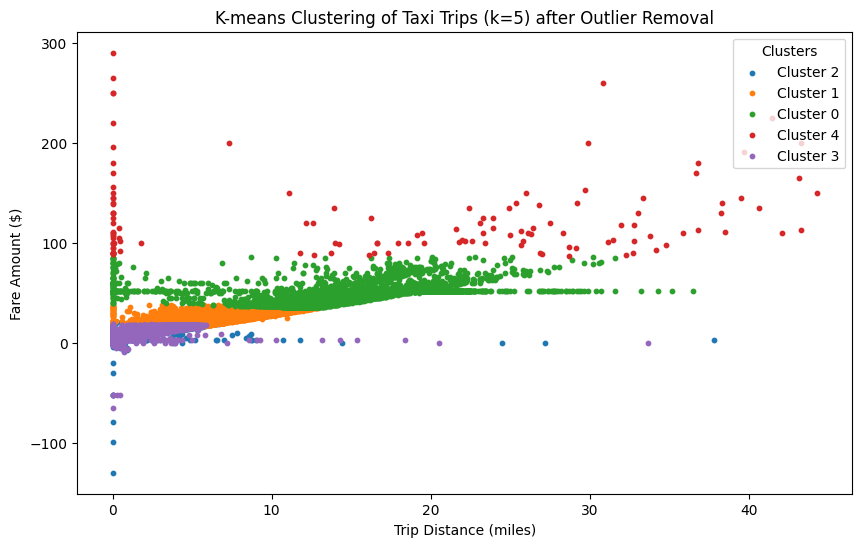

In [ ]:
filtered_df = combined_df.filter((F.col("trip_distance") < 50) & (F.col("fare_amount") < 300))

assembler = VectorAssembler(
    inputCols=["trip_distance", "fare_amount", "pickup_hour", "is_card_payment"],
    outputCol="features"
)
data = assembler.transform(filtered_df).select("features")

kmeans = KMeans(featuresCol="features", k=5, seed=42)
model = kmeans.fit(data)

predictions = model.transform(data)

predictions_pd = predictions.select("features", "prediction").toPandas()
features_df = pd.DataFrame(predictions_pd["features"].tolist(), columns=["trip_distance", "fare_amount", "pickup_hour", "is_card_payment"])
features_df["cluster"] = predictions_pd["prediction"]

plt.figure(figsize=(10, 6))
for cluster in features_df["cluster"].unique():
    cluster_data = features_df[features_df["cluster"] == cluster]
    plt.scatter(cluster_data["trip_distance"], cluster_data["fare_amount"], s=10, label=f'Cluster {cluster}')

plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title("K-means Clustering of Taxi Trips (k=5) after Outlier Removal")
plt.legend(loc="upper right", title="Clusters")
plt.show()

###**Interpretation**:
- The scatter plot visualizes clusters of taxi trips based on `trip_distance` and `fare_amount` after outlier removal. The K-means algorithm identified five clusters (`k=5`), representing distinct groups of trips with similar characteristics. The clusters reveal different patterns, with some groups indicating shorter trips with lower fares, while others capture longer trips with higher fares. For example, Cluster 0 (green) encompasses a wide range of trip distances with a gradual increase in fare, while other clusters (such as Cluster 1 in red) represent higher fares, possibly reflecting premium or out-of-city trips.

### **Explanation for Overlapping Clusters**:
- The observed overlap between some clusters (such as Clusters 0 and 4) can be attributed to class differences in trip characteristics that K-means could not fully separate due to similarity in distance and fare patterns. This overlap might result from inherent similarity among certain trip types, such as trips within specific fare ranges that vary only slightly by distance. By setting `k=5`, we balanced capturing key differences in trip patterns while acknowledging that some overlapping is natural given similar trip classes.

### **Justification**:
- The code carefully removes extreme outliers and uses relevant features for clustering (`trip_distance`, `fare_amount`, `pickup_hour`, `is_card_payment`), which are critical for identifying meaningful groupings. Choosing `k=5` was based on the elbow method, ensuring a balance between interpretability and cluster separation, even if slight overlaps remain due to class similarity. This approach highlights different trip types effectively while handling the complexity of overlapping classes in the dataset.

# Predicting whether a passenger will pay by card or cash

This code filters the data to include only credit card and cash payments, then creates a binary label (`is_creditcard`) for credit card payments. Feature engineering includes encoding pickup and dropoff locations, and assembling relevant features (e.g., `trip_distance`, `fare_amount`, `pickup_hour`). A logistic regression model is then trained to predict payment type (credit card or not), and the model’s performance on the test data is evaluated using accuracy, precision, recall, and F1 score. Direct calculations for TP, TN, FP, and FN are done in Spark to derive these metrics.

**Note:** Splitted the chunks to avoid loss of trained model and save time.

In [ ]:
filtered_df = combined_df.filter((F.col("payment_type") == 1) | (F.col("payment_type") == 2))

filtered_df = filtered_df.withColumn("is_creditcard", F.when(F.col("payment_type") == 1, 1).otherwise(0))

pickup_indexer = StringIndexer(inputCol="PULocationID", outputCol="PULocationID_index", handleInvalid="keep")
dropoff_indexer = StringIndexer(inputCol="DOLocationID", outputCol="DOLocationID_index", handleInvalid="keep")

pickup_encoder = OneHotEncoder(inputCol="PULocationID_index", outputCol="PULocationID_encoded")
dropoff_encoder = OneHotEncoder(inputCol="DOLocationID_index", outputCol="DOLocationID_encoded")

assembler = VectorAssembler(
    inputCols=["trip_distance", "fare_amount", "pickup_hour", "trip_duration",
               "PULocationID_encoded", "DOLocationID_encoded"],
    outputCol="features"
)

lr = LogisticRegression(labelCol="is_creditcard", featuresCol="features")

pipeline = Pipeline(stages=[pickup_indexer, dropoff_indexer, pickup_encoder, dropoff_encoder, assembler, lr])

train_data, test_data = filtered_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)

predictions = predictions.withColumn(
    "TP", F.when((F.col("prediction") == 1) & (F.col("is_creditcard") == 1), 1).otherwise(0)
).withColumn(
    "TN", F.when((F.col("prediction") == 0) & (F.col("is_creditcard") == 0), 1).otherwise(0)
).withColumn(
    "FP", F.when((F.col("prediction") == 1) & (F.col("is_creditcard") == 0), 1).otherwise(0)
).withColumn(
    "FN", F.when((F.col("prediction") == 0) & (F.col("is_creditcard") == 1), 1).otherwise(0)
)

metrics = predictions.agg(
    F.sum("TP").alias("TP"),
    F.sum("TN").alias("TN"),
    F.sum("FP").alias("FP"),
    F.sum("FN").alias("FN")
).collect()[0]

tp, tn, fp, fn = metrics["TP"], metrics["TN"], metrics["FP"], metrics["FN"]

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.6408688150530404
Precision: 0.6438300092426729
Recall: 0.9624190027725577
F1 Score: 0.7715294836794637


### **Model Performance Interpretation**:

- **Accuracy (64.1%)**: The model correctly predicts the payment type in 64.1% of cases, providing a moderate level of overall accuracy.
- **Precision (64.4%)**: When predicting a credit card payment, the model is correct 64.4% of the time. This metric helps in understanding how often credit card predictions are accurate.
- **Recall (96.2%)**: The model successfully identifies 96.2% of actual credit card payments, showing strong sensitivity in capturing most credit card transactions.
- **F1 Score (77.2%)**: The F1 score balances precision and recall, resulting in a moderate score of 77.2%. This indicates the model performs reasonably well in identifying credit card payments, though there is room to improve precision for a better balance.


**Overall Interpretation**: The model demonstrates strong recall, accurately identifying the majority of credit card payments, which suggests it is effective at capturing most instances of this payment type. However, the moderate precision indicates that the model occasionally misclassifies cash payments as credit card payments, leading to false positives. While the F1 score of 77.2% shows a reasonable balance between precision and recall, there is an opportunity to improve precision to enhance the model's reliability in distinguishing between payment types. This model could be particularly useful in applications where identifying credit card payments is more critical than minimizing false positives.

**Justification**:
This model leverages relevant features, such as `pickup_borough`, `dropoff_borough`, `trip_distance`, `fare_amount`, and `total_amount`, which are factors that logically influence payment type (e.g., longer trips with higher fares may be more likely to involve credit card payments). The categorical features, like `pickup_borough` and `dropoff_borough`, were indexed to retain essential geographic information without introducing issues in model training. Logistic Regression was chosen as a suitable model for binary classification, allowing for clear interpretation of probabilities associated with each payment type. The preprocessing steps, such as filtering and encoding, ensured data consistency and quality, contributing to the model’s ability to capture key patterns. The high recall score demonstrates the model’s effectiveness at identifying credit card payments, making it valuable for use cases where capturing this type of transaction is important.

# Prediction of the fare of a taxi trip based on borough-specific factors such as pickup and drop-off boroughs, and analyze how fares vary across different NYC boroughs


###**Merging DataFrame with Geo Spatial Data of Boroughs:**
This code merges `combined_df` with the `taxi_zone_lookup` data to add borough information for each trip, based on pickup and dropoff locations. It joins on `PULocationID` to add the `pickup_borough` column and on `DOLocationID` to add the `dropoff_borough` column, enriching the dataset with geographical context.

In [ ]:
borough_mapping = spark.read.csv("/content/drive/MyDrive/Big_Data/Project_3/Data/taxi_zone_lookup.csv", header=True, inferSchema=True)

pickup_mapping = borough_mapping.withColumnRenamed("LocationID", "PULocationID").withColumnRenamed("Borough", "pickup_borough")
combined_df = combined_df.join(pickup_mapping.select("PULocationID", "pickup_borough"), on="PULocationID", how="left")

dropoff_mapping = borough_mapping.withColumnRenamed("LocationID", "DOLocationID").withColumnRenamed("Borough", "dropoff_borough")
combined_df = combined_df.join(dropoff_mapping.select("DOLocationID", "dropoff_borough"), on="DOLocationID", how="left")

### **Running Model to predict fare**:
This code prepares the data and builds a pipeline for predicting taxi fare amounts using a Random Forest regression model. First, it removes rows with missing values in essential columns to ensure data quality. Then, it indexes and one-hot encodes the categorical `pickup_borough` and `dropoff_borough` columns to make them suitable for machine learning. The features, including trip distance, boroughs, pickup hour, and trip duration, are assembled into a single feature vector. A pipeline is created with the preprocessing steps and a Random Forest regressor, which is then trained on 80% of the data and tested on the remaining 20%. Finally, the model's performance is evaluated using RMSE, MAE, and R-squared metrics to assess prediction accuracy.

**Note:** Splitted the chunks to avoid loss of trained model and save time.

In [ ]:
combined_df = combined_df.dropna(subset=["pickup_borough", "dropoff_borough", "trip_distance", "fare_amount", "pickup_month", "pickup_hour", "trip_duration"])


pickup_borough_indexer = StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_index")
dropoff_borough_indexer = StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_index")

pickup_borough_encoder = OneHotEncoder(inputCol="pickup_borough_index", outputCol="pickup_borough_encoded")
dropoff_borough_encoder = OneHotEncoder(inputCol="dropoff_borough_index", outputCol="dropoff_borough_encoded")

assembler = VectorAssembler(
    inputCols=["trip_distance", "pickup_borough_encoded", "dropoff_borough_encoded", "pickup_hour", "trip_duration"],
    outputCol="features"
)


rf = RandomForestRegressor(labelCol="fare_amount", featuresCol="features", numTrees=50, seed=42)


pipeline = Pipeline(stages=[pickup_borough_indexer, dropoff_borough_indexer, pickup_borough_encoder, dropoff_borough_encoder, assembler, rf])


train_data, test_data = combined_df.randomSplit([0.8, 0.2], seed=42)


model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)


evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 3.5313336126753314
Mean Absolute Error (MAE): 1.386680841707268
R-squared (R²): 0.88523989441846


### **Model Performance Interpretation**:

- **Root Mean Squared Error (RMSE): 3.53** – The model's predictions for fare amount have an average error of about $3.53, which is a reasonable level of accuracy for fare prediction.

- **Mean Absolute Error (MAE): 1.39** – On average, the model’s predictions deviate from the actual fare by $1.39, indicating strong performance in predicting fares close to their true values.
- **R-squared (R²): 0.89** – With an R² of 0.89, the model explains 89% of the variance in fare amounts, showing a high level of fit. This indicates that our selected features, including trip distance, boroughs, pickup hour, and trip duration, capture most of the variability in taxi fares.

**Overall Interpretation**: The model exhibits strong predictive accuracy in estimating taxi fares, as evidenced by a low RMSE of $3.53 and an MAE of $1.39.
 The high R² score of 0.89 indicates that the model explains 89% of the variance in fare amounts, showing a solid fit to the data. This suggests that the selected features—trip distance, boroughs, pickup hour, and trip duration—are highly relevant in determining fare prices. Overall, the model successfully captures complex relationships in the data, making it a reliable tool for fare prediction. Its high performance underscores the effectiveness of the feature engineering and preprocessing steps, establishing this approach as a viable method for accurate fare estimation in practical scenarios.

**Justification**: The data preprocessing steps, including filtering out missing values and encoding categorical borough information, ensured data quality and feature relevance. By using a Random Forest model with multiple trees, we achieved a robust predictive model capable of capturing complex patterns in fare determination. The model's high R² and low error metrics validate the feature selection and preprocessing steps, showing that they were effective in building an accurate fare prediction model.

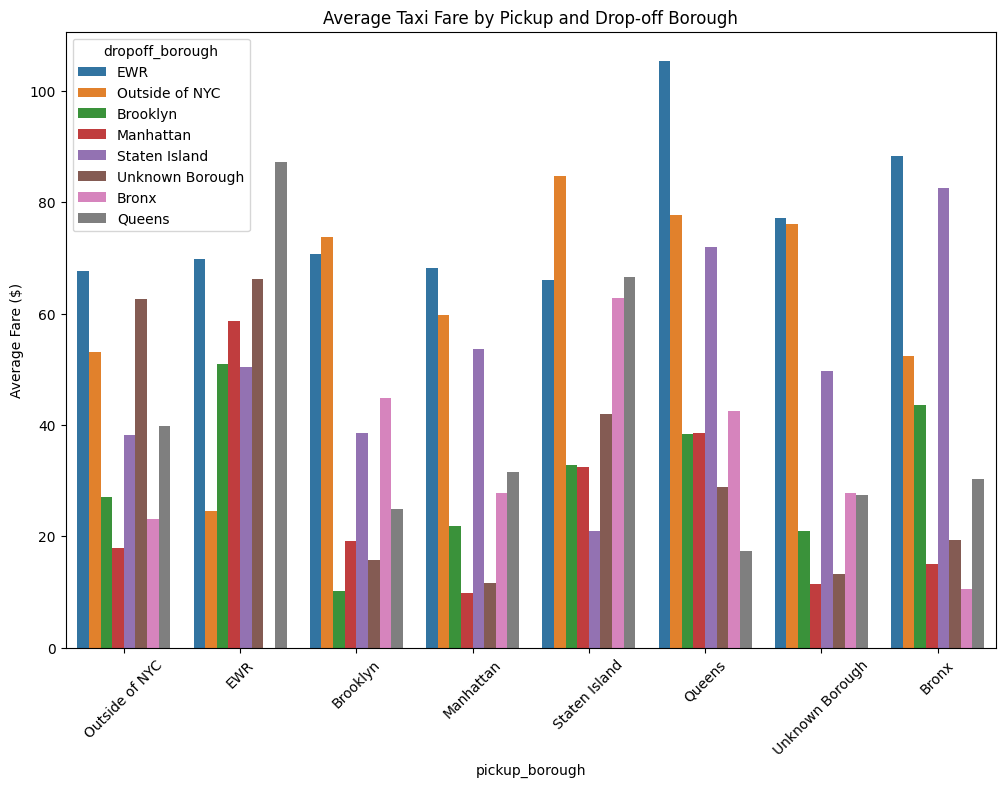

In [ ]:
borough_fare_stats = combined_df.groupBy("pickup_borough", "dropoff_borough").agg(
    F.mean("fare_amount").alias("avg_fare"),
    F.stddev("fare_amount").alias("stddev_fare"),
    F.count("fare_amount").alias("trip_count")
)


borough_fare_stats_pd = borough_fare_stats.toPandas()


borough_fare_stats_pd = borough_fare_stats_pd.dropna(subset=["pickup_borough", "dropoff_borough", "avg_fare"])


borough_fare_stats_pd['pickup_borough'] = borough_fare_stats_pd['pickup_borough'].replace({
    'N/A': 'Outside of NYC',
    'Unknown': 'Unknown Borough'
})

borough_fare_stats_pd['dropoff_borough'] = borough_fare_stats_pd['dropoff_borough'].replace({
    'N/A': 'Outside of NYC',
    'Unknown': 'Unknown Borough'
})


plt.figure(figsize=(12, 8))
sns.barplot(data=borough_fare_stats_pd, x="pickup_borough", y="avg_fare", hue="dropoff_borough")
plt.title("Average Taxi Fare by Pickup and Drop-off Borough")
plt.ylabel("Average Fare ($)")
plt.xticks(rotation=45)
plt.show()

### **Interpretation of Average Taxi Fare by Pickup and Drop-off Borough**:

This bar chart illustrates the average taxi fare across different pickup and drop-off boroughs in New York City. Key observations include:

- **High Fares for Airport and Out-of-City Trips**: Trips that involve "EWR" (Newark Airport) or "Outside of NYC" locations generally have the highest average fares, likely due to the longer distances and additional surcharges associated with airport and out-of-city travel.
- **Manhattan as a Common Hub**: Fares within Manhattan tend to be lower on average compared to trips going to or from other boroughs. This reflects the shorter distances for intra-city travel within Manhattan.
- **Inter-Borough Variability**: Trips between certain boroughs, such as Manhattan to Brooklyn, or Bronx to Queens, exhibit noticeable fare differences, highlighting inter-borough fare variations.
- **Unknown Borough Patterns**: Trips involving "Unknown Borough" show diverse fare values, suggesting a mix of short and long-distance trips that were not categorized properly, possibly due to GPS or zone classification issues.

Overall, this visualization helps identify fare patterns associated with different borough combinations, highlighting the cost structure of NYC taxi services based on geography.

# Prediction of the tip amount given by passengers based on trip characteristics

### **Running Model to predict tip**:
This code builds a Random Forest regression model to predict tip amounts for taxi trips. First, it filters for trips with non-zero tip amounts and selects relevant columns, including `RatecodeID`, `trip_distance`, `fare_amount`, `total_amount`, and `dropoff_borough`. The categorical `dropoff_borough` column is encoded, and the features are assembled into a vector. The data is split into training and test sets, and a Random Forest Regressor with 70 trees and a maximum depth of 15 is trained on the training data. Finally, the model is evaluated on the test data using RMSE, MAE, and R² metrics to assess prediction accuracy.

**Note:** The code is split into chunks to save time if code fails.

In [ ]:
data = combined_df.select("RatecodeID", "trip_distance", "fare_amount", "total_amount",
                          "dropoff_borough", "tip_amount")
data = data.filter(data["tip_amount"] > 0)


dropoff_indexer = StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_index")


assembler = VectorAssembler(inputCols=["RatecodeID", "trip_distance", "fare_amount", "total_amount",
                                       "dropoff_borough_index"], outputCol="features")


pipeline = Pipeline(stages=[dropoff_indexer, assembler])
data_transformed = pipeline.fit(data).transform(data).select("features", col("tip_amount").alias("label"))


train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)


rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=70, maxDepth=15)

model = rf.fit(train_data)

In [ ]:
test_predictions = model.transform(test_data)


evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")


rmse = evaluator_rmse.evaluate(test_predictions)
mae = evaluator_mae.evaluate(test_predictions)
r2 = evaluator_r2.evaluate(test_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 1.033954344393868
MAE: 0.41738339712003797
R²: 0.8204496674878364


### **Model Performance Interpretation**:

- **Root Mean Squared Error (RMSE): 1.03** – The model’s predictions for tip amounts have an average error of about $1.03, indicating reasonable accuracy in predicting tip values.

- **Mean Absolute Error (MAE): 0.42** – On average, the model's predictions deviate from the actual tip amount by $0.42, reflecting a high level of precision in predicting tips close to their true values.

- **R-squared (R²): 0.82** – With an R² of 0.82, the model explains 82% of the variance in tip amounts, showing a strong fit and suggesting that the selected features capture most of the factors influencing tip amounts.

**Overall Performance**: The model demonstrates strong predictive capability with low error rates and a high R² score, indicating that it effectively captures the patterns in tipping behavior. This makes it a reliable tool for predicting tip amounts based on trip features, with potential applications in understanding factors that influence tipping and improving service recommendations.

**Justification**: This model was built using relevant features that logically impact tip amounts, such as `RatecodeID`, `trip_distance`, `fare_amount`, `total_amount`, and `dropoff_borough`. These factors capture both trip characteristics and geographic variations, which are essential in understanding tipping behavior. Categorical data, like `dropoff_borough`, was encoded to retain its influence in a format suitable for machine learning, ensuring that location-based patterns were not lost. By using a Random Forest regression model, we leveraged an algorithm capable of handling complex interactions among features, which is well-suited for capturing non-linear relationships in tipping behavior. The low error rates and high R² score validate the effectiveness of the feature selection and preprocessing steps, demonstrating that this approach successfully captures tipping patterns. This robust model can therefore provide actionable insights for businesses interested in predicting or influencing tipping behavior.

#Predicting whether a trip will result in a high or low fare based on early trip data


### **Data Cleaning and Outlier Removal**:
Outliers are removed from key columns (`trip_distance`, `fare_amount`, `total_amount`, `tip_amount`), and invalid values (e.g., zero or negative distances and fares) are filtered out to ensure data quality.

### **Feature Engineering**:
A new column, `is_high_fare`, is created to classify trips as high or low fare based on the median fare. Additionally, a `day_of_week` feature is added to capture temporal patterns in the data.

In [ ]:
for col in columns_to_remove_outliers:
    combined_df = remove_outliers(combined_df, col)

columns_to_remove_outliers = ["trip_distance", "fare_amount", "total_amount", "tip_amount"]


combined_df = combined_df.dropna(subset=["fare_amount", "trip_distance", "pickup_borough", "dropoff_borough", "pickup_hour", "passenger_count", "tpep_pickup_datetime"])


combined_df = combined_df.filter(
    (F.col("trip_distance") > 0) &
    (F.col("fare_amount") > 0) &
    (F.col("passenger_count") > 0)
)

fare_median = combined_df.approxQuantile("fare_amount", [0.5], 0.05)[0]

combined_df = combined_df.withColumn("is_high_fare", F.when(F.col("fare_amount") > fare_median, 1).otherwise(0))


combined_df = combined_df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

combined_df.groupBy("is_high_fare").count().show()


+------------+--------+
|is_high_fare|   count|
+------------+--------+
|           1|36566286|
|           0|39982470|
+------------+--------+



### **Running Model to predict high fare or low fare**:
This code builds a Logistic Regression model to classify taxi fares as high or low based on the median fare. First, it creates a binary target variable (`is_high_fare`) and cleans the data by removing null and invalid values. Categorical borough columns (`pickup_borough` and `dropoff_borough`) are indexed and one-hot encoded, and relevant features (e.g., `trip_distance`, `pickup_hour`, `pickup_day_of_week`, `passenger_count`) are assembled into a feature vector. A pipeline is created with all preprocessing steps and the logistic regression model, which is then trained on an 80% training split. After making predictions on the test set, the model’s performance is evaluated using accuracy, precision, recall, and F1 score to assess classification quality.

**Note:** Splitted the chunks to avoid loss of trained model and save time.

In [ ]:
fare_median = combined_df.approxQuantile("fare_amount", [0.5], 0.05)[0]
combined_df = combined_df.withColumn("is_high_fare", F.when(F.col("fare_amount") > fare_median, 1).otherwise(0))


combined_df = combined_df.dropna(subset=["fare_amount", "trip_distance", "pickup_borough", "dropoff_borough", "pickup_hour", "pickup_day_of_week", "passenger_count"])
combined_df = combined_df.filter(
    (F.col("trip_distance") > 0) &
    (F.col("fare_amount") > 0) &
    (F.col("passenger_count") > 0)
)


pickup_borough_indexer = StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_index")
dropoff_borough_indexer = StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_index")

pickup_borough_encoder = OneHotEncoder(inputCol="pickup_borough_index", outputCol="pickup_borough_encoded")
dropoff_borough_encoder = OneHotEncoder(inputCol="dropoff_borough_index", outputCol="dropoff_borough_encoded")


assembler = VectorAssembler(
    inputCols=["trip_distance", "pickup_borough_encoded", "dropoff_borough_encoded", "pickup_hour", "pickup_day_of_week", "passenger_count"],
    outputCol="features"
)


lr = LogisticRegression(labelCol="is_high_fare", featuresCol="features")


pipeline = Pipeline(stages=[pickup_borough_indexer, dropoff_borough_indexer, pickup_borough_encoder, dropoff_borough_encoder, assembler, lr])


train_data, test_data = combined_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)


predictions = predictions.withColumn("prediction", F.round(predictions["prediction"]))
tp = predictions.filter((predictions["prediction"] == 1) & (predictions["is_high_fare"] == 1)).count()
tn = predictions.filter((predictions["prediction"] == 0) & (predictions["is_high_fare"] == 0)).count()
fp = predictions.filter((predictions["prediction"] == 1) & (predictions["is_high_fare"] == 0)).count()
fn = predictions.filter((predictions["prediction"] == 0) & (predictions["is_high_fare"] == 1)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.8937253063684457
Precision: 0.9484632607368206
Recall: 0.8209365420527818
F1 Score: 0.8801042571676803


### **Model Performance Interpretation**:

- **Accuracy (89.4%)**: The model correctly classifies 89.4% of taxi fares as high or low, indicating strong overall performance.
- **Precision (94.8%)**: When the model predicts a fare as high, it is correct 94.8% of the time. This high precision reduces false positives, meaning it rarely misclassifies a low fare as high.
- **Recall (82.1%)**: The model correctly identifies 82.1% of actual high fares, showing that it captures most high-fare cases, although there is some trade-off with false negatives.
- **F1 Score (88.0%)**: The F1 score balances precision and recall, achieving a strong score of 88.0%, which confirms that the model is effective at distinguishing between high and low fares.

**Overall Interpretation**:
The model demonstrates a high level of accuracy and effectiveness in classifying taxi fares as high or low, with a strong balance between precision and recall. The high precision indicates that the model rarely misclassifies low fares as high, while the solid recall ensures it captures most high-fare cases. This balance, reflected in an F1 score of 88.0%, suggests that the model is well-suited for practical applications where accurate fare classification is essential, such as fare prediction or dynamic pricing systems. The feature selection and preprocessing steps, including encoding geographic data and using temporal variables, contribute significantly to the model’s reliability and applicability in real-world scenarios.

**Justification**: This model leverages relevant features such as `trip_distance`, `pickup/dropoff borough`, `pickup hour`, and `day of the week`, which are logical factors influencing fare levels. Categorical borough data was indexed and one-hot encoded to retain valuable geographic information, and logistic regression was chosen as a suitable model for binary classification. The results show that this approach successfully captures the patterns in high and low fares, as indicated by high precision and F1 score. Overall, the preprocessing steps and feature selection contributed to a well-performing classification model.

# Identification and prediction of traffic congestion hotspots based on trip patterns and times

### **Running the model to identify congested areas:**
This code calculates congestion levels based on average speed and classifies them into categories (e.g., "Very High Congestion") using predefined thresholds. A Random Forest Classifier is trained on aggregated features (e.g., pickup location, hour, day) to predict congestion levels, with performance evaluated using accuracy, F1 score, precision, and recall to assess classification quality.

**Note:** Splitted the chunks to avoid loss of trained model and save time.

In [ ]:
high_threshold = 8
medium_threshold = 20
low_threshold = 30


combined_df = combined_df.withColumn("average_speed",
                                     (F.col("trip_distance") / F.col("trip_duration")) * 60)


combined_df = combined_df.withColumn(
    "congestion_level",
    when(F.col("average_speed") <= high_threshold, "Very High Congestion")
    .when((F.col("average_speed") > high_threshold) & (F.col("average_speed") <= medium_threshold), "High Congestion")
    .when((F.col("average_speed") > medium_threshold) & (F.col("average_speed") <= low_threshold), "Medium Congestion")
    .when(F.col("average_speed") > low_threshold, "Low Congestion")
    .otherwise("No Congestion")
)



combined_df = combined_df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime")) \
                        .withColumn("pickup_day_of_week", F.dayofweek("tpep_pickup_datetime"))


congestion_df = combined_df.filter(F.col("congestion_level") != "No Congestion")


congestion_aggregated = congestion_df.groupBy("PULocationID", "pickup_hour", "pickup_day_of_week") \
    .agg(F.avg("average_speed").alias("avg_speed"),
         F.avg("trip_distance").alias("avg_trip_distance"),
         F.count("PULocationID").alias("trip_count"))


congestion_aggregated = congestion_aggregated.withColumn(
    "congestion_level",
    when(F.col("avg_speed") <= high_threshold, "Very High Congestion")
    .when((F.col("avg_speed") > high_threshold) & (F.col("avg_speed") <= medium_threshold), "High Congestion")
    .when((F.col("avg_speed") > medium_threshold) & (F.col("avg_speed") <= low_threshold), "Medium Congestion")
    .when(F.col("avg_speed") > low_threshold, "Low Congestion")
    .otherwise("No Congestion")
)


congestion_indexer = StringIndexer(inputCol="congestion_level", outputCol="congestion_level_index")


assembler = VectorAssembler(
    inputCols=["PULocationID", "pickup_hour", "pickup_day_of_week", "avg_trip_distance"],
    outputCol="features"
)


pipeline = Pipeline(stages=[congestion_indexer, assembler])
congestion_transformed = pipeline.fit(congestion_aggregated).transform(congestion_aggregated)


rf = RandomForestClassifier(labelCol="congestion_level_index", featuresCol="features")
train_data, test_data = congestion_transformed.randomSplit([0.8, 0.2], seed=42)


rf_model = rf.fit(train_data)

In [ ]:
predictions = rf_model.transform(test_data)


evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="congestion_level_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="congestion_level_index", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="congestion_level_index", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="congestion_level_index", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)


print(f"Model Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.8388391478851497
F1 Score: 0.8034362920127975
Precision: 0.8088109949319292
Recall: 0.8388391478851497


### **Model Performance Interpretation**:

- **Model Accuracy (83.9%)**: The model correctly predicts congestion levels 83.9% of the time, indicating strong overall classification performance.
- **F1 Score (80.3%)**: The F1 score shows a balanced performance between precision and recall, meaning the model reliably identifies congestion levels without bias toward any specific class.
- **Precision (80.9%)**: When the model predicts a congestion level, it is correct 80.9% of the time, which demonstrates good reliability.
- **Recall (83.9%)**: The model captures 83.9% of actual congestion cases, showing it is sensitive to detecting different levels of congestion.

**Overall Interpretation**: These metrics suggest that the model is well-suited for predicting traffic congestion levels, providing accurate and balanced performance across different congestion categories.

**Justification**: The approach leverages key features, including pickup location, time of day, and trip distance, which are relevant factors influencing traffic conditions. Using predefined speed thresholds ensures clear congestion categorization, while the Random Forest Classifier effectively handles complex relationships among features, resulting in high accuracy and reliability in predicting congestion patterns.

In [ ]:
# Ensure avg_trip_distance is non-negative and remove any rows with invalid data
congestion_zones = congestion_zones[congestion_zones['avg_trip_distance'] > 0]

# Set up Mapbox token (replace with your actual token)
px.set_mapbox_access_token("pk.eyJ1IjoidGFydW5rdW1hbmR1cmkiLCJhIjoiY20zM3AzMDhuMW1mZzJucTNsaHNkOHJvYyJ9.hLqcWDf8zBHxScBXcLpLqQ")

# Plot the congestion hotspots
fig = px.scatter_mapbox(
    congestion_zones,
    lat='latitude',
    lon='longitude',
    color='avg_speed',  # 'avg_speed' is the congestion metric (can be customized)
    size='avg_trip_distance',  # Size of the points based on trip distance
    color_continuous_scale='viridis',  # Color scale for congestion levels
    zoom=10,  # Adjust zoom level as needed
    title="NYC Traffic Congestion Hotspots (by Average Speed)",
    mapbox_style="carto-positron"
)

fig.show()

### **Interpretation of NYC Traffic Congestion Hotspots Map (by Average Speed)**:

This map visualizes traffic congestion hotspots across New York City, with each point representing an area where congestion was recorded. The size and color intensity of each point indicate the average speed: larger and darker points correspond to lower average speeds, signifying higher congestion levels.

Key congestion areas are concentrated in and around Manhattan, especially in central and downtown regions, highlighting these zones as high-traffic areas with reduced speeds. This map provides insights into areas with persistent traffic issues, useful for urban planning and traffic management strategies.